## European Restaurant Reviews
Reviews of various European restaurants by customers.
This dataset contains customer reviews for various restaurants, divided into positive and negative sentiments. Reviews are crucial for each restaurant’s reputation and are updated daily.

https://www.kaggle.com/datasets/gorororororo23/european-restaurant-reviews

In [2]:
import os
print(os.getcwd())

C:\Users\HENNY PURWADI\PYTHON\FT_Embed\FineTune_Embed


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', 160)

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics

import joblib
import pickle
from imblearn.over_sampling import SMOTE

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Read CSV file
df = pd.read_csv('./data/Reviews.csv')
df.head(2)

,Sentiment,Label,Review
0,Negative,0,Rude managerThe manager became agressive when I said the carbonara was not good. She was rude. It was a very bad experience. The worst in Rome in many years.
1,Negative,0,"A big disappointmentI ordered a beef fillet ask to be done medium, I got it well done cooked and very dry, when I told them they took the steak and after 20..."


In [8]:
len(df)

1502

In [10]:
df.columns

Index(['Sentiment', 'Label', 'Review'], dtype='object')

In [12]:
#Find unique values in df['Sentiment'] 
unique_Sentiment= df['Sentiment'] .unique()
df_Sentiment_counts = df['Sentiment'].value_counts()
df_Sentiment_counts

Sentiment
Positive    1237
Negative     265
Name: count, dtype: int64

### There is an imbalanced dataset of sentiments between Positive and Negative

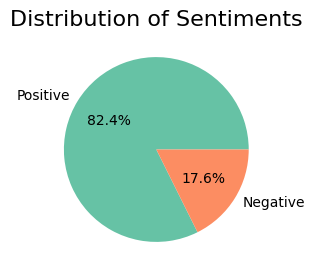

In [15]:
plt.figure(figsize=(3, 3))
plt.pie(df_Sentiment_counts, labels=df_Sentiment_counts.index, autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Distribution of Sentiments', fontsize=16)
plt.show()

When using BERT or similar pre-trained transformer models for embedding, We don't need to apply traditional text preprocessing steps like TF-IDF, regex cleaning, or other NLP techniques like stemming or lemmatization. BERT models handle these preprocessing steps internally, including tokenization and handling of special characters.

### Use DistilBertForSequenceClassification to predict Sentiment in the Reviews dataset.


In [18]:
# Preprocess the text data using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [20]:
# Function to tokenize data
def tokenize_data(reviews, labels):
    encodings = tokenizer(reviews, truncation=True, padding=True, max_length=128)
    dataset = [{'input_ids': torch.tensor(encodings['input_ids'][i]),
                'attention_mask': torch.tensor(encodings['attention_mask'][i]),
                'labels': torch.tensor(labels[i])} for i in range(len(reviews))]
    return dataset

In [22]:
# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Review'], df['Label'], test_size=0.3, random_state=42)

train_dataset = tokenize_data(train_texts.tolist(), train_labels.tolist())
test_dataset = tokenize_data(test_texts.tolist(), test_labels.tolist())

In [24]:
# Calculate class weights for handling imbalanced data
class_weights = torch.tensor([len(train_labels) / (len(np.unique(train_labels)) * np.bincount(train_labels))], dtype=torch.float)
class_weights = class_weights.squeeze()

In [26]:
# Load DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# Training arguments for evaluation
training_args = TrainingArguments(
    output_dir='./results',          
    per_device_eval_batch_size=16,   
    logging_dir='./logs',            
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Trainer initialization for evaluation
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [30]:
# Evaluate the model
metrics = trainer.evaluate()
print("Metrics:", metrics)

Metrics: {'eval_loss': 0.5906973481178284, 'eval_model_preparation_time': 0.0, 'eval_accuracy': 0.835920177383592, 'eval_f1': 0.9106280193236715, 'eval_precision': 0.835920177383592, 'eval_recall': 1.0, 'eval_runtime': 16.8587, 'eval_samples_per_second': 26.752, 'eval_steps_per_second': 1.72}


In [34]:
# Get predictions for the test set
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
with torch.no_grad():
    test_outputs = model(**test_encodings)
test_preds = torch.argmax(test_outputs.logits, dim=1).numpy()

In [35]:
# Calculate accuracy score
accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8359
Precision: 0.8359
Recall: 1.0000
F1 Score: 0.9106


In [38]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
nconf_matrix = np.round(conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis], 2)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  0  74]
 [  0 377]]


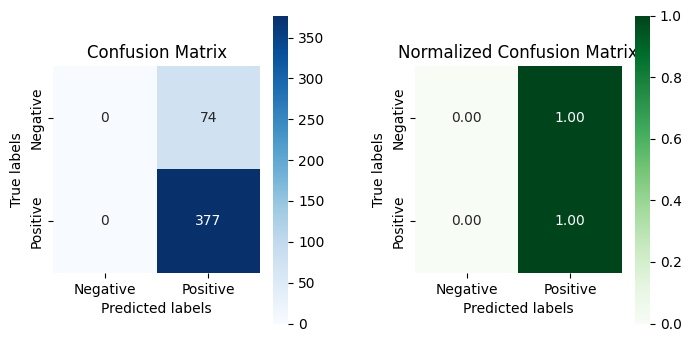

In [40]:
# Plot heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Blues, fmt="d", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax1)
ax1.set_xlabel("Predicted labels")
ax1.set_ylabel("True labels")
ax1.set_title("Confusion Matrix")
sns.heatmap(nconf_matrix, annot=True, cmap=plt.cm.Greens, fmt=".2f", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax2)
ax2.set_xlabel("Predicted labels")
ax2.set_ylabel("True labels")
ax2.set_title("Normalized Confusion Matrix")

# Add some space between the subplots
plt.subplots_adjust(wspace=0.4)

# Set the aspect ratio to "equal"
ax1.set_aspect("equal")
ax2.set_aspect("equal")

plt.show()

### **Interpretation:**

100% of class 0 (Negative) were incorrectly classified as class 1 (Positive) , and 100% of class 1 instances were correctly classified as class 1 (1.0).

The model performs well for class 1 (Positive) with high precision, recall, and F1-score.

The model fails to identify any instances of class 0 (Negative), resulting in a precision, recall, and F1-score of 0 for this class.

The overall accuracy is driven by the high performance on class 1, but the performance on class 0 is poor.

This suggests a significant class imbalance problem, where the model has likely learned to predict the majority class (class 1) and ignore minority class (class 0)